# **DSR DengAI Project Competition**
# Team: Justin, Adam, Eugene, Paul 

| **Pipeline Steps**                                              | **Script files**                          |
|-----------------------------------------------------------|-------------------------------------------|
| 1) Read and pre-process data                              | pre_processing.py                         |
| 2) Feature engineering                                    | feature_engineering.py                    |
| 3) Train models                                           | model_training.py, <br>tree_model_training.py |
| 4) Predict on test_features <br>and write submission file | final_predict.py                          |

## Introduction 

Overall strategy and tools utilised

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import scripts.pre_processing as pp
import scripts.feature_engineering as fe
import scripts.tree_model_training as tm
import scripts.linear_model_training as lm
from scripts.model_evaluation import regression_evaluation
import scripts.final_predict as fp
import scripts.data_viz as dv

# PIPELINE

## 1) Pre-process data

In [2]:
# Read in data files 
train_features = pd.read_csv('./data/dengue_features_train.csv')
train_target = pd.read_csv('./data/dengue_labels_train.csv')
test_features = pd.read_csv('./data/dengue_features_test.csv')

In [3]:
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=False)

# Run processing and split by city
train_iq = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=False)
train_sj = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=False)

# Run checks for missing values
assert train_iq.isnull().any().any() == False
assert train_sj.isnull().any().any() == False
Xy_iq = train_iq.copy()
Xy_sj = train_sj.copy()
print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 24)
train_sj shape: (928, 24)


## 2) Feature engineering

In [4]:
# Run feature engineering 
Xy_iq = fe.cyclical_encode_date(Xy_iq)
Xy_sj = fe.cyclical_encode_date(Xy_sj)
#Xy_iq = fe.shift_features(Xy_iq, periods=1)
#Xy_sj = fe.shift_features(Xy_sj, periods=1)
Xy_iq = fe.drop_date(Xy_iq)
Xy_sj = fe.drop_date(Xy_sj)
Xy_iq = fe.add_rolling2(Xy_iq, 'iq', fillna=True)
Xy_sj = fe.add_rolling2(Xy_sj, 'sj', fillna=True)

print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 47)
train_sj shape: (928, 47)


### Charting different features 

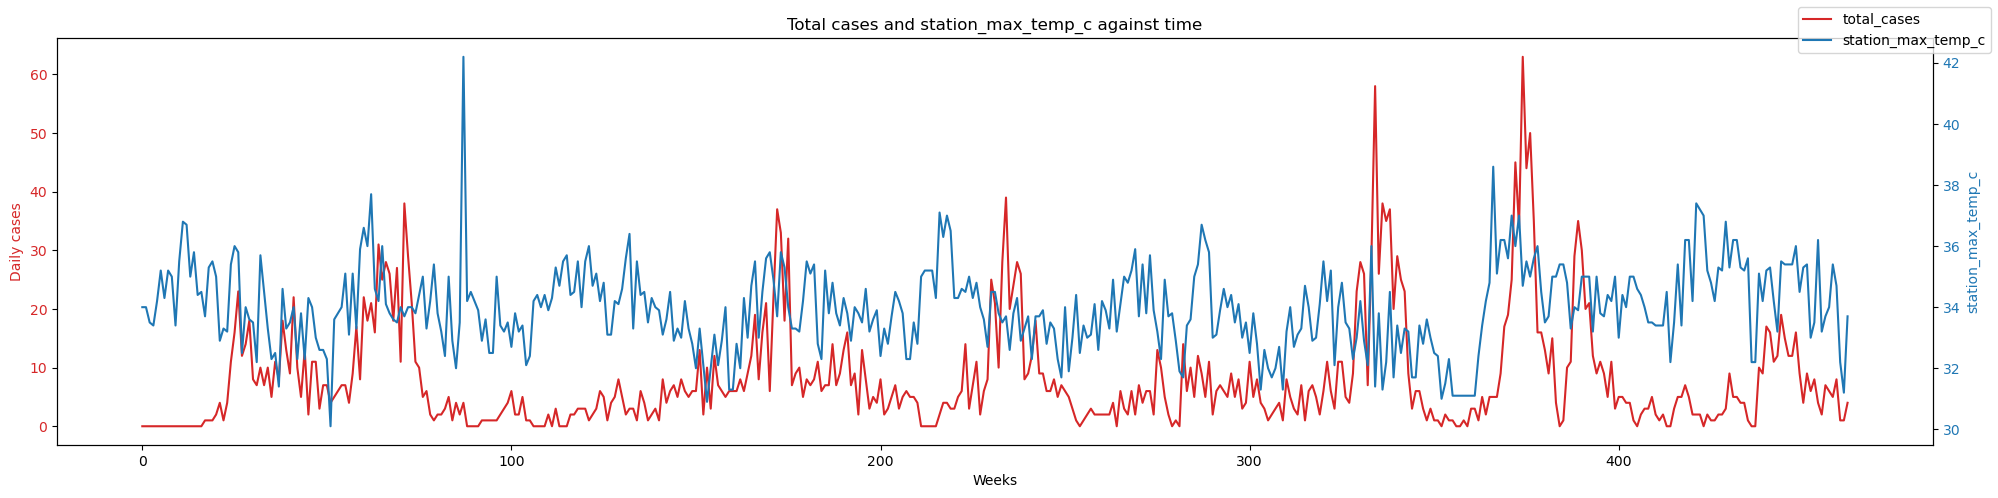

In [5]:
data = Xy_iq
y = Xy_iq['total_cases']
feature = 'station_max_temp_c'
dv.feature_output_chart(data, y, feature, city='iq')


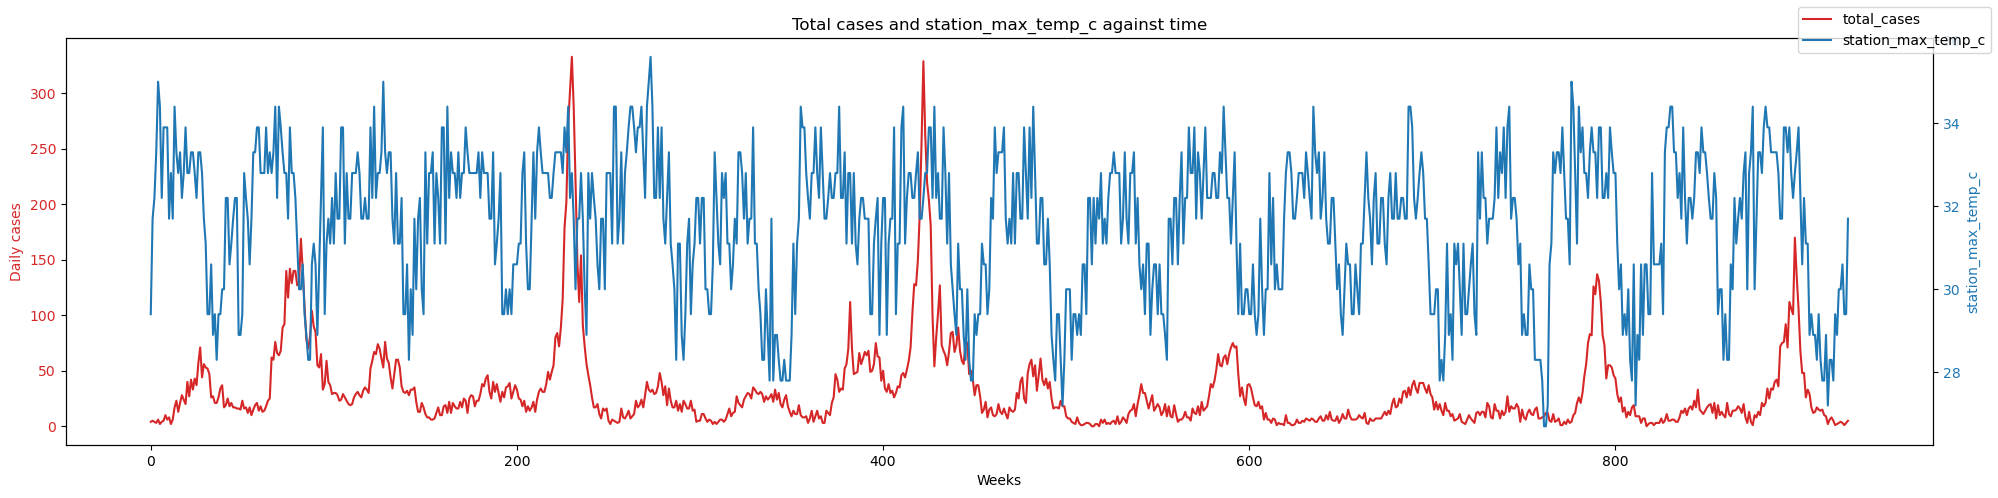

In [6]:
data = Xy_sj
y = Xy_sj['total_cases']
feature = 'station_max_temp_c'
dv.feature_output_chart(data, y, feature, city='sj')

### Utilising rolling averages 

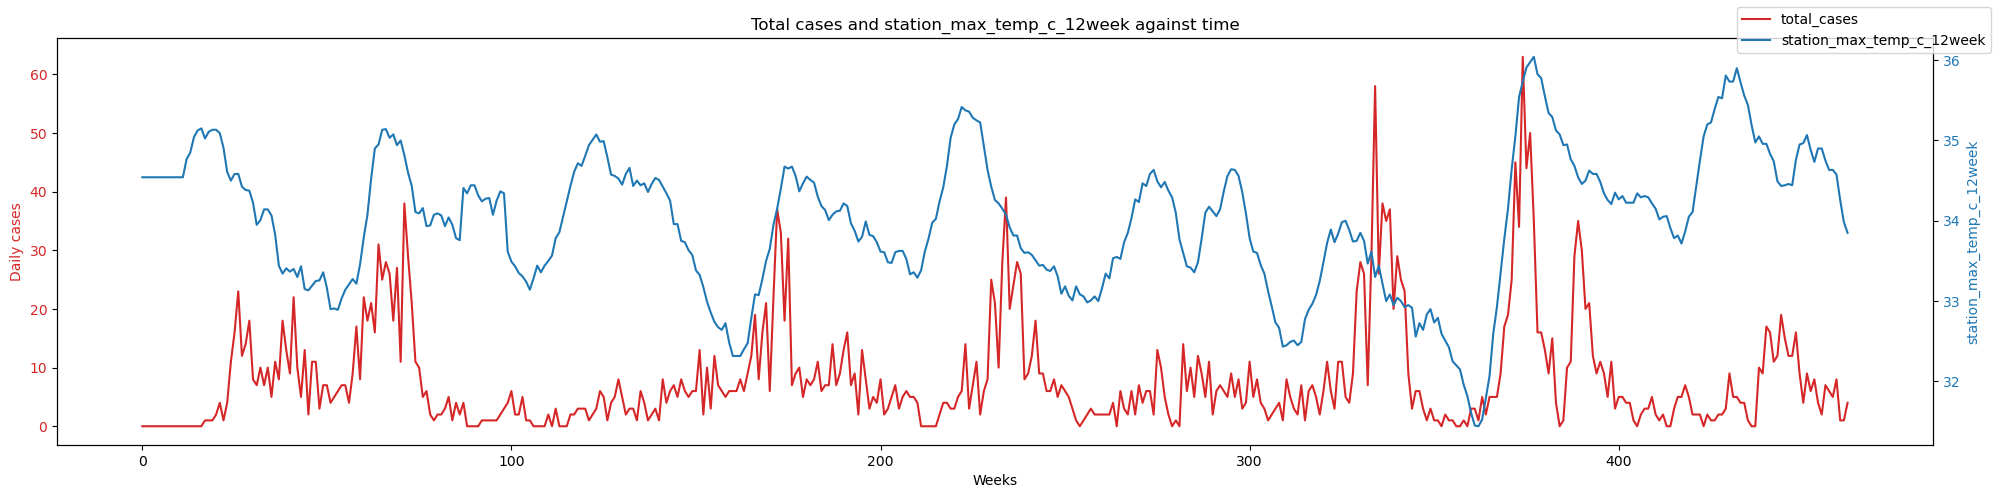

In [8]:
data = Xy_iq
y = Xy_iq['total_cases']
feature = 'station_max_temp_c_12week'
dv.feature_output_chart(data, y, feature, city='iq')


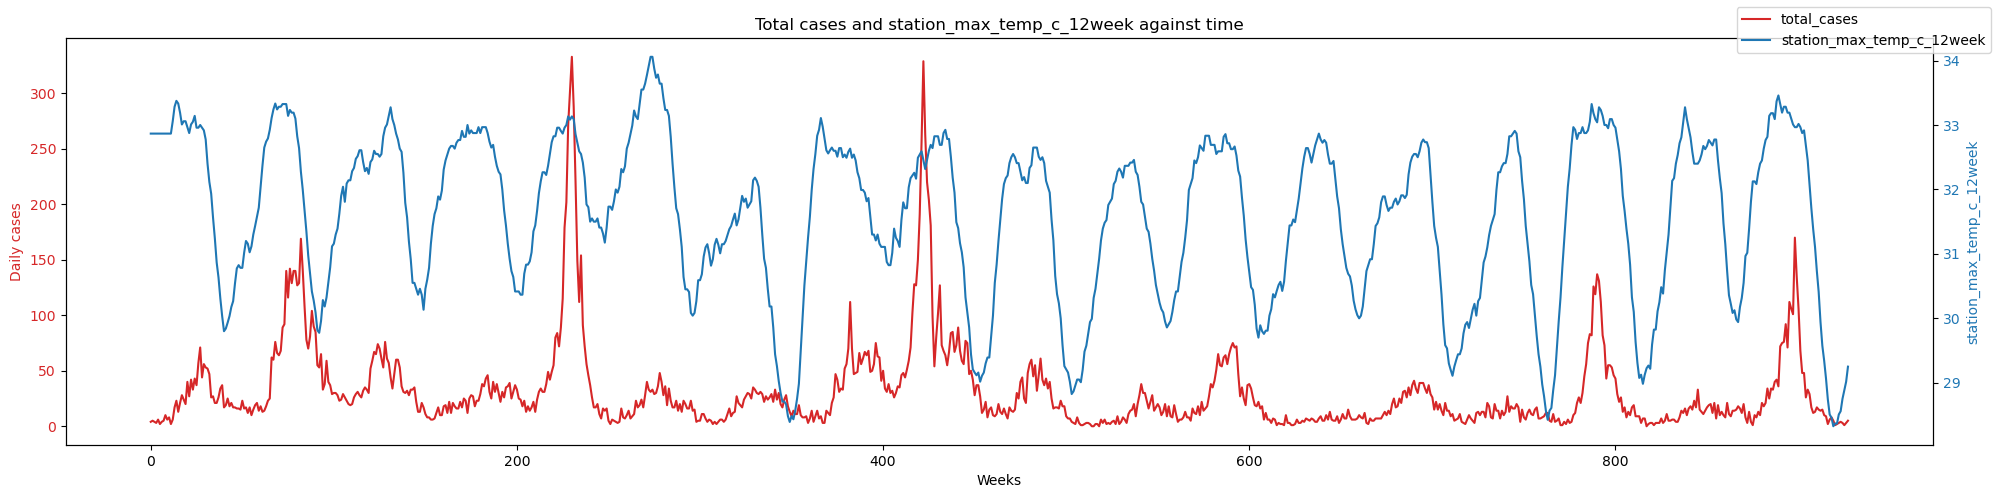

In [9]:
data = Xy_sj
y = Xy_sj['total_cases']
feature = 'station_max_temp_c_12week'
dv.feature_output_chart(data, y, feature, city='sj')

### Dashboard

In [10]:
# Plotly plot 
import plotly.io as pio
pio.renderers.default = "browser"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

scaler = MinMaxScaler()
sj_scaled = scaler.fit_transform(Xy_sj)
sj_scaled = pd.DataFrame(columns=Xy_sj.columns, data= sj_scaled, index=Xy_sj.index)
iq_scaled = scaler.fit_transform(Xy_iq)
iq_scaled = pd.DataFrame(columns=Xy_iq.columns, data= iq_scaled, index=Xy_iq.index)

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles = ["San Juan", "Iquitos"], 
                    vertical_spacing=0.02)
n_colors = iq_scaled.shape[1]
colors = px.colors.sample_colorscale("turbo", [n/(n_colors -1) for n in range(n_colors)])


for i, c in enumerate(sj_scaled.columns):
    fig.add_trace(go.Scatter(x=sj_scaled.index, 
                             y=sj_scaled.loc[:,c],
                             mode='lines', # 'lines' or 'markers'
                             name=c,
                             line_color=colors[i],
                             legendgroup=f'group{i}',
                             showlegend=False,),
                  
                  row=1, col=1)

for i, c in enumerate(iq_scaled.columns):
    fig.add_trace(go.Scatter(x=iq_scaled.index, 
                             y=iq_scaled.loc[:,c],
                             mode='lines', # 'lines' or 'markers'
                             line_color=colors[i],
                             legendgroup=f'group{i}',
                             name=c),
                 row=2, col=1)
fig.show()

### Select features that we want for the model

In [11]:
Xy_iq = fe.remove_original_cols(Xy_iq)
Xy_sj = fe.remove_original_cols(Xy_sj)

Text(0.5, 1.0, 'San Juan Variable Correlations')

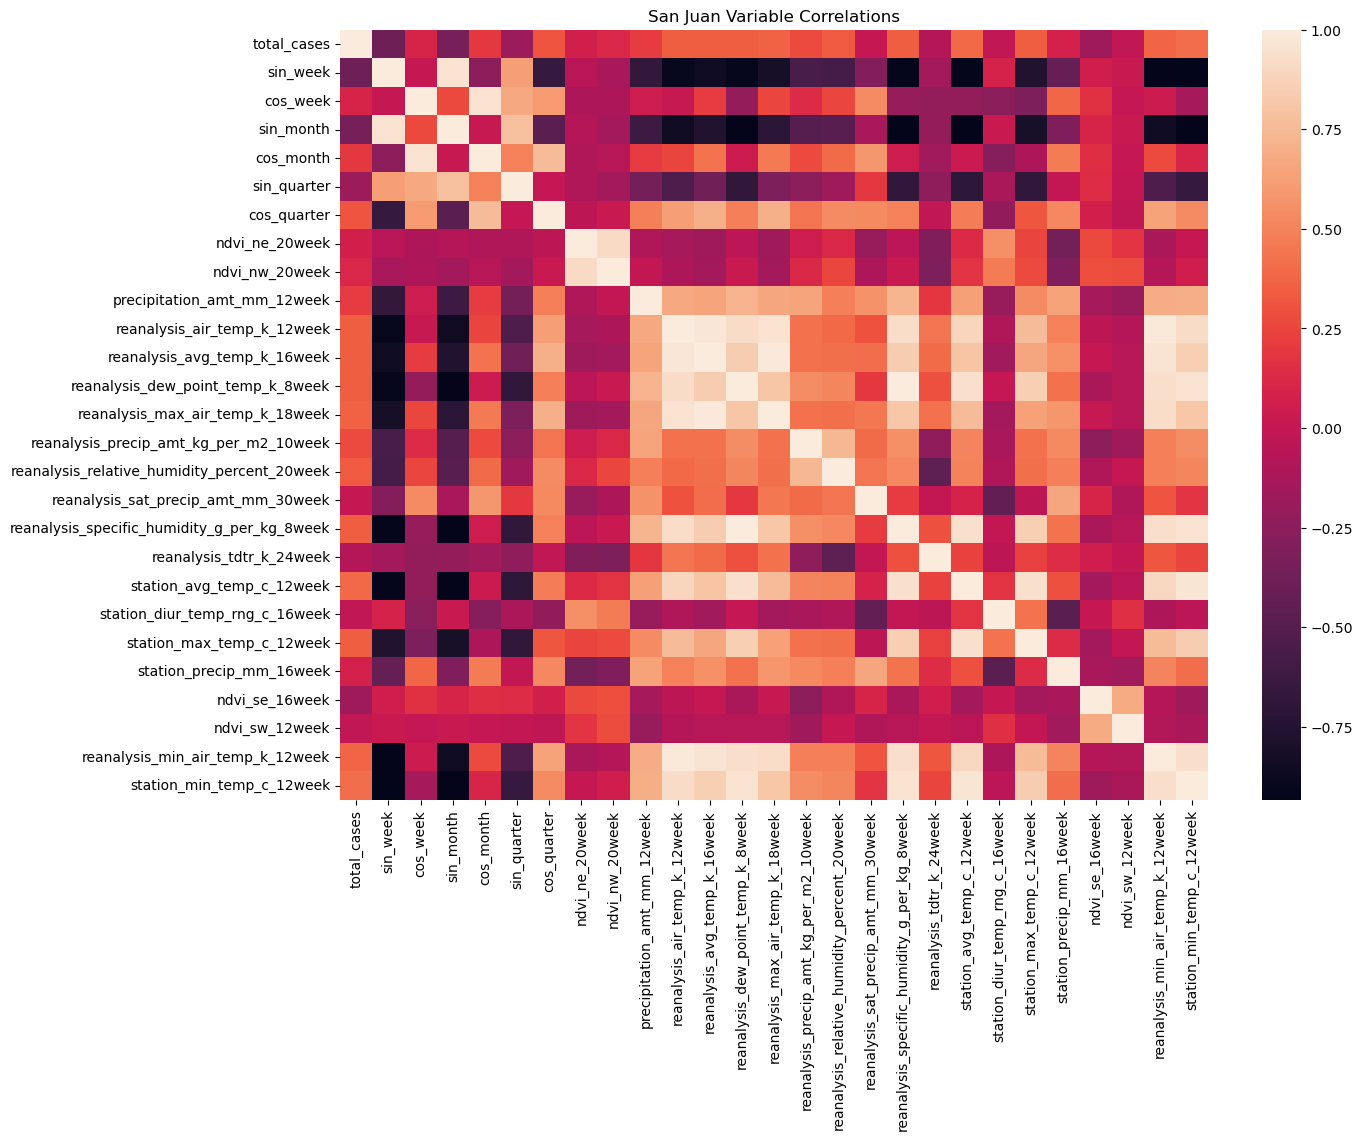

In [12]:
plt.figure(figsize=(14,10))
sj_corr_heat = sns.heatmap(Xy_sj.corr()) 
plt.title('San Juan Variable Correlations') 

Text(0.5, 1.0, 'San Juan Variable Correlations')

<Figure size 1400x1000 with 0 Axes>

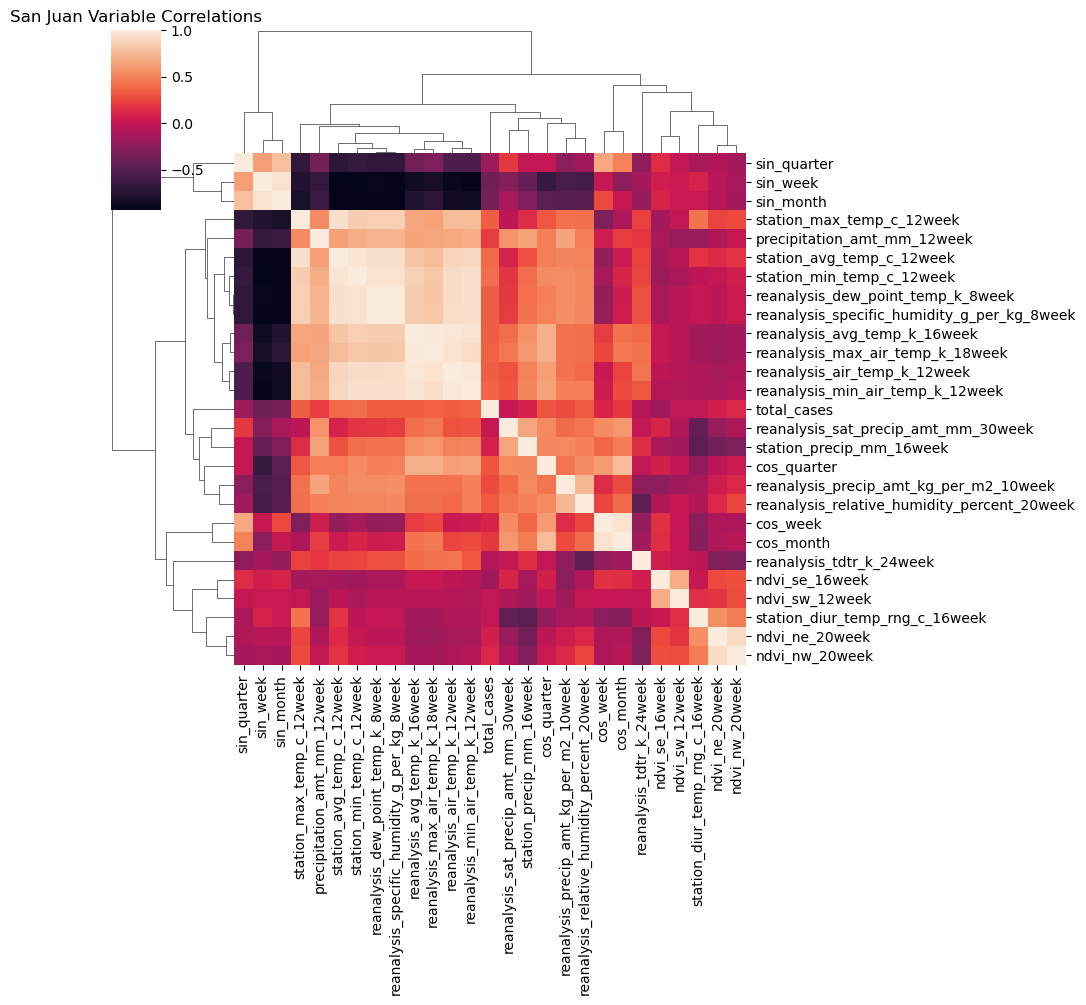

In [13]:
plt.figure(figsize=(14,10))
sj_corr_heat = sns.clustermap(Xy_sj.corr())
plt.title('San Juan Variable Correlations')

## 3) Train models

In [14]:
# Split data into X and y
X_iq = Xy_iq.drop(labels=['total_cases'], axis=1)
y_iq = Xy_iq['total_cases']
X_sj = Xy_sj.drop(labels=['total_cases'], axis=1)
y_sj = Xy_sj['total_cases']
assert len(X_iq) == len(y_iq)

### Baseline model

Using the mean daily cases (by city) as the prediction

For training data:
- For Iquitos:  MAE 6.4
- For San Juan: MAE 24.3

For test data after submission:
**MAE 27.9**

In [15]:
# Baseline model predictions for Iquitos (Iq)
bl_pred_train = np.tile(np.mean(y_iq), len(y_iq))
bl_pred_test = np.tile(np.mean(y_iq), len(y_iq))
print('For Iquitos: ')
regression_evaluation(y_iq, y_iq, bl_pred_train, bl_pred_test)

# Baseline model predictions for San Jose (sj)
bl_pred_train = np.tile(np.mean(y_sj), len(y_sj))
bl_pred_test = np.tile(np.mean(y_sj), len(y_sj))
print('For San Jose: ')
regression_evaluation(y_sj, y_sj, bl_pred_train, bl_pred_test)

For Iquitos: 

    Evaluation metrics:
        RMSE train: 9.24327523359923
        RMSE test: 9.24327523359923
        MAE train: 6.380110930218457
        MAE test: 6.380110930218457 
    
For San Jose: 

    Evaluation metrics:
        RMSE train: 39.06484683794444
        RMSE test: 39.06484683794444
        MAE train: 24.198600995838284
        MAE test: 24.198600995838284 
    


(39.06484683794444, 39.06484683794444, 24.198600995838284, 24.198600995838284)

### Poisson regression model

In [16]:
warnings.filterwarnings('ignore') 
# Poisson regression model for iq
X, y = X_iq, y_iq
lm.poisson_reg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,8.758192,4.909873,6.073100,3.526113,0.6,100
1,1,8.845919,4.528577,6.274763,3.291546,0.6,200
2,1,8.701808,4.959765,6.025715,3.572008,1.0,100
3,1,8.674345,4.771214,6.081550,3.448893,1.0,200
4,2,11.300010,6.569266,7.972475,4.571154,0.6,100
5,2,11.534682,6.514718,8.050300,4.527132,0.6,200
6,2,11.369095,6.678632,7.806673,4.684326,1.0,100
7,2,11.343156,6.580941,7.975862,4.591293,1.0,200


In [16]:
# Poisson regression model for sj
X, y = X_sj, y_sj
lm.poisson_reg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,44.907347,23.541100,29.220078,14.154745,0.6,100
1,1,70.480513,18.318156,54.039273,11.722089,0.6,200
2,1,61.677984,19.262291,45.675361,11.975631,1.0,100
3,1,55.591082,19.419843,40.785759,11.854698,1.0,200
4,2,25.996666,35.265974,17.287578,20.062329,0.6,100
5,2,28.005108,33.746717,21.210366,19.390957,0.6,200
6,2,25.873464,35.209191,17.820410,19.969193,1.0,100
7,2,26.086665,33.370156,19.147138,19.320105,1.0,200


<Axes: >

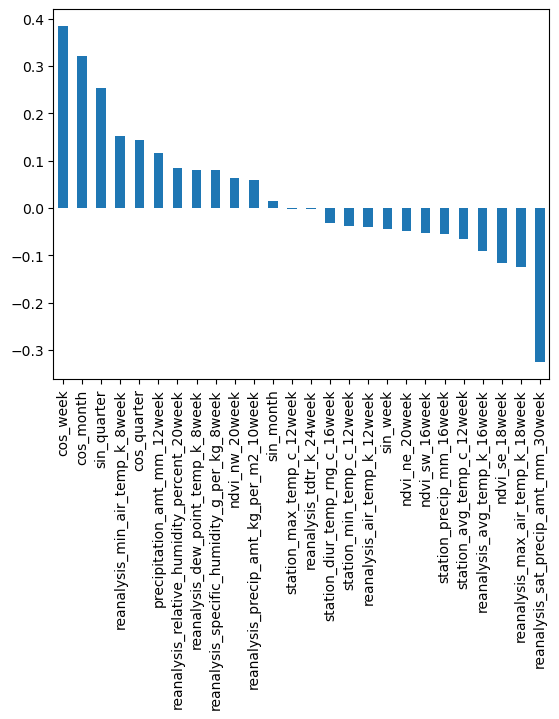

In [17]:
# Poisson get parameters for iq 
X, y = X_iq, y_iq
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

<Axes: >

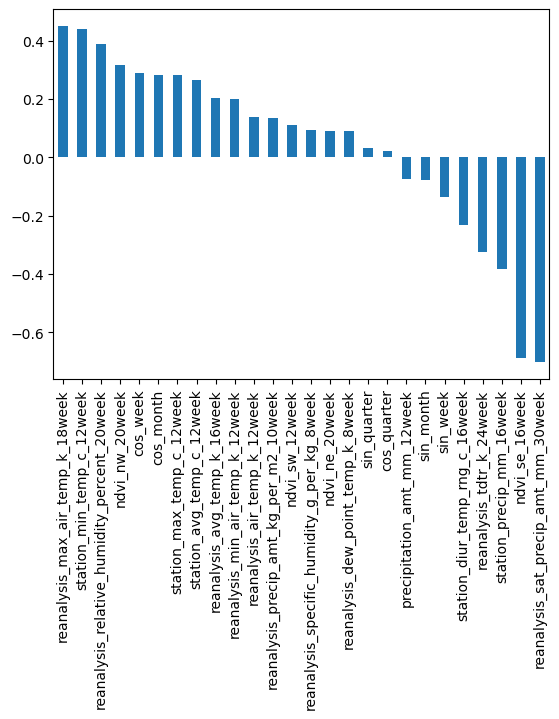

In [18]:
# Poisson get parameters for sj 
X, y = X_sj, y_sj
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

### Random forest model

In [19]:
# Random forest model for iq
X, y = X_iq, y_iq
tm.rforest_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,n_estimators,max_depth,min_samples_split,min_samples_leaf
0,1,8.713158,3.382284,5.795522,2.557982,100,4,2,2
1,1,8.606394,3.364307,5.693224,2.478625,100,4,5,2
2,1,8.582332,2.390184,5.688371,1.586618,100,8,2,2
3,1,8.507423,2.586107,5.646419,1.734551,100,8,5,2
4,1,8.576510,3.367490,5.632736,2.496510,200,4,2,2
5,1,8.520333,3.398217,5.616177,2.530774,200,4,5,2
6,1,8.728885,2.418270,5.787205,1.631194,200,8,2,2
7,1,8.470051,2.565340,5.558166,1.680366,200,8,5,2
8,2,11.499957,4.854664,7.879396,3.428706,100,4,2,2
9,2,11.552550,4.873926,7.583028,3.469260,100,4,5,2


<Axes: >

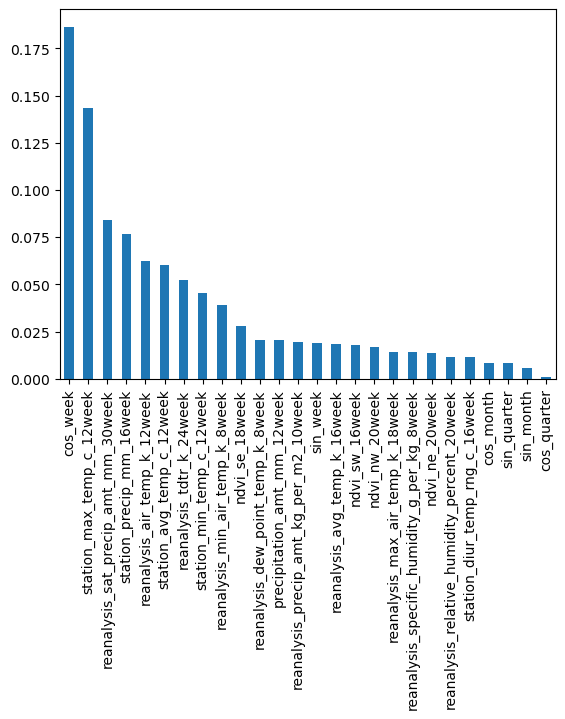

In [20]:
# Random forest feature importance for iq
X, y = X_iq, y_iq
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

<Axes: >

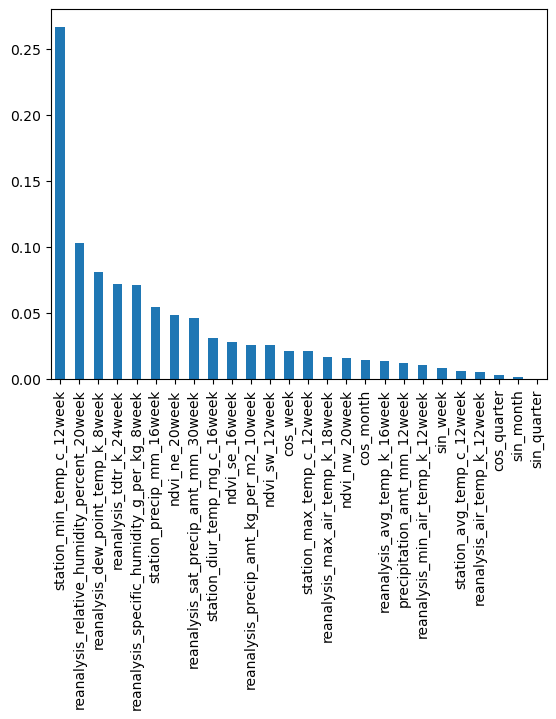

In [21]:
# Random forest feature importance for sj
X, y = X_sj, y_sj
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

### XGBoost model

In [19]:
# XG boost model for iq
X, y = X_iq, y_iq
score_iq, plots_iq = tm.xg_model(X, y)
score_iq.sort_values(by='mae_test', ascending=True)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
7,1,8.404932,2.598921,5.439858,1.524876,0.05,100,6,0.6,0.8,10,10
4,1,8.416327,2.599574,5.474536,1.525235,0.05,100,5,0.6,0.8,10,10
1,1,8.454597,2.658489,5.502610,1.579612,0.05,100,4,0.6,0.8,10,10
3,1,8.615791,2.102925,5.512026,1.272381,0.05,100,5,0.6,0.8,5,10
0,1,8.595818,2.201337,5.545476,1.366846,0.05,100,4,0.6,0.8,5,10
2,1,8.491565,3.344167,5.584139,1.933252,0.05,100,4,0.6,0.8,20,10
8,1,8.479739,3.300282,5.617704,1.892776,0.05,100,6,0.6,0.8,20,10
5,1,8.486350,3.324489,5.618954,1.898109,0.05,100,5,0.6,0.8,20,10
6,1,8.769082,2.063555,5.642733,1.243709,0.05,100,6,0.6,0.8,5,10
13,2,11.600383,2.895593,6.901910,1.830395,0.05,100,5,0.6,0.8,10,10


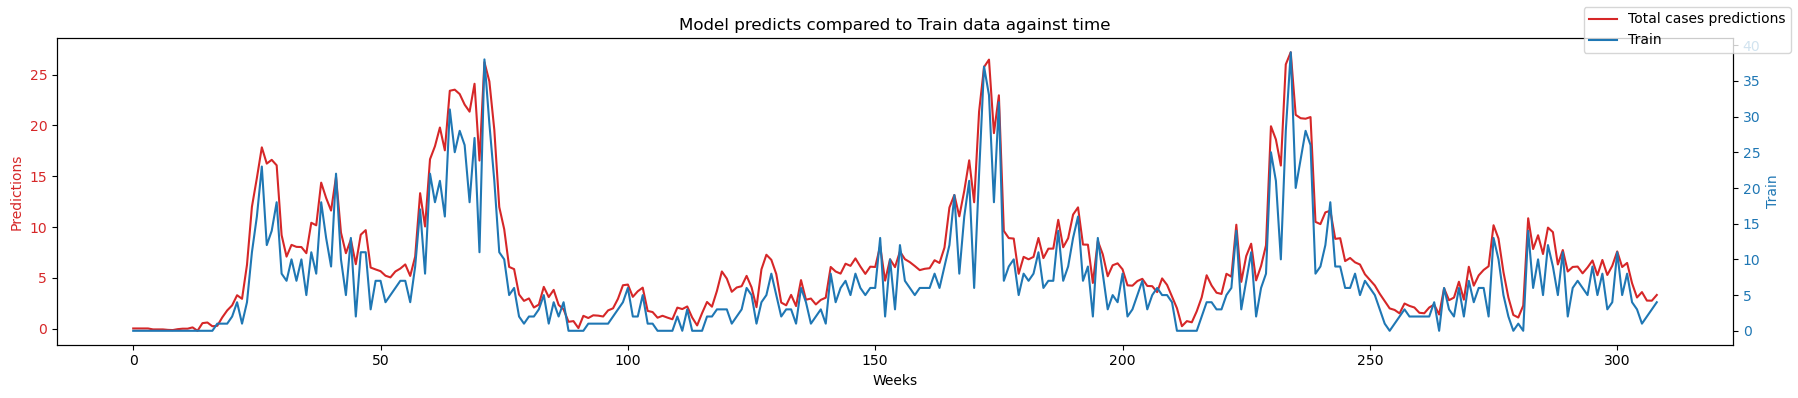

In [20]:
row = 12
y_pred = plots_iq[row]['pred_train']
y = plots_iq[row]['y_train']
test_or_train = 'Train'
dv.plot_train_test(y_pred, y, test_or_train=test_or_train)


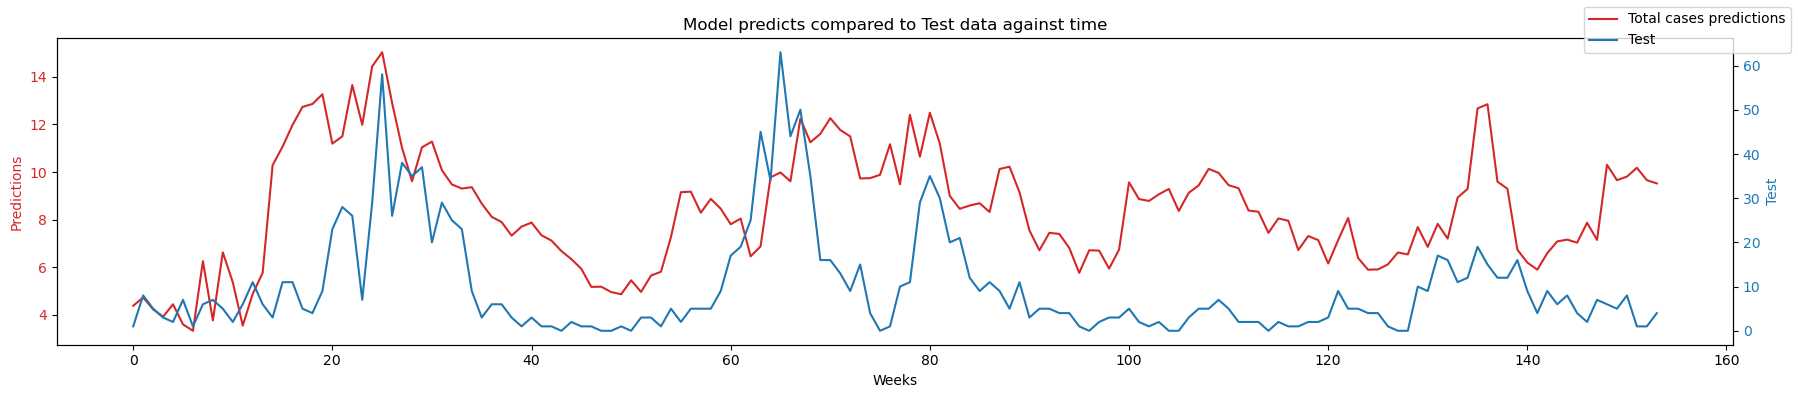

In [21]:
row = 12
y_pred = plots_iq[row]['pred_test']
y = plots_iq[row]['y_test']
test_or_train = 'Test'
dv.plot_train_test(y_pred, y, test_or_train=test_or_train)


In [22]:
# XG boost model for sj
X, y = X_sj, y_sj
tm.xg_model(X, y)
score_sj, plots_sj = tm.xg_model(X, y)
score_sj.sort_values(by='mae_test', ascending=True)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
17,2,25.486057,14.973172,17.034145,6.275915,0.05,100,6,0.6,0.8,20,10
16,2,25.937695,11.021017,18.818681,4.918921,0.05,100,6,0.6,0.8,10,10
14,2,26.037044,16.042205,18.862891,7.107948,0.05,100,5,0.6,0.8,20,10
13,2,25.516558,11.870079,19.542633,5.732547,0.05,100,5,0.6,0.8,10,10
10,2,24.648671,14.085599,19.721246,7.400052,0.05,100,4,0.6,0.8,10,10
11,2,25.991270,17.818081,20.058743,8.485042,0.05,100,4,0.6,0.8,20,10
15,2,25.620919,8.055387,20.227072,4.002982,0.05,100,6,0.6,0.8,5,10
12,2,26.849371,9.233058,21.753299,5.013229,0.05,100,5,0.6,0.8,5,10
8,1,39.348618,18.221690,22.950060,6.213946,0.05,100,6,0.6,0.8,20,10
4,1,38.542586,13.389194,22.972020,4.922945,0.05,100,5,0.6,0.8,10,10


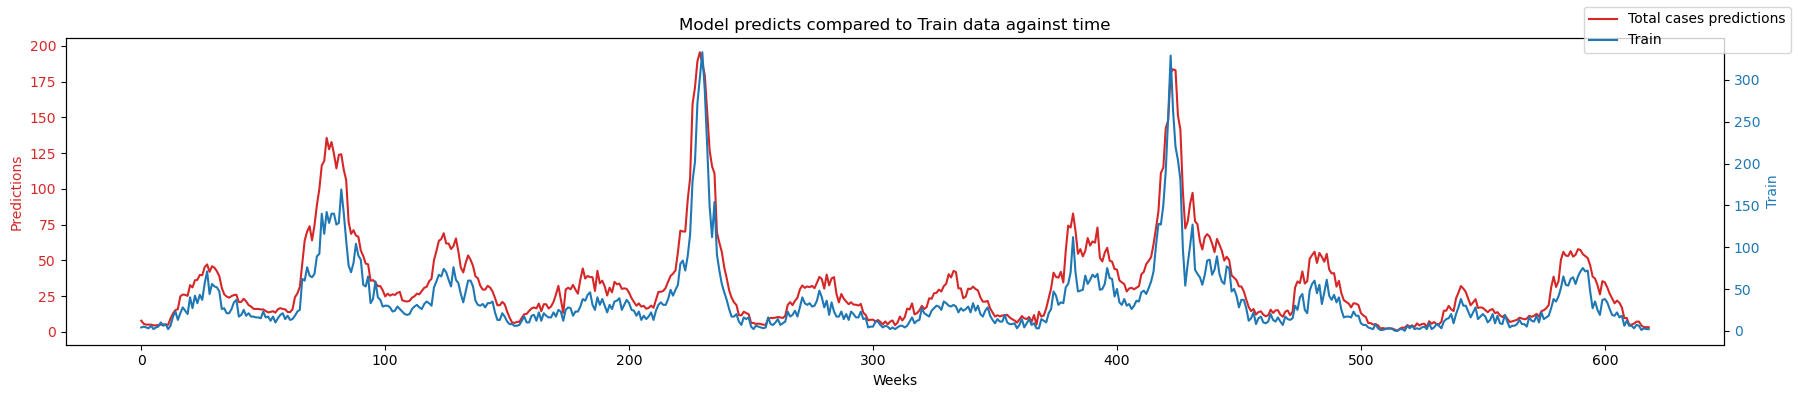

In [23]:
row = 17
y_pred = plots_sj[row]['pred_train']
y = plots_sj[row]['y_train']
test_or_train = 'Train'
dv.plot_train_test(y_pred, y, test_or_train=test_or_train)


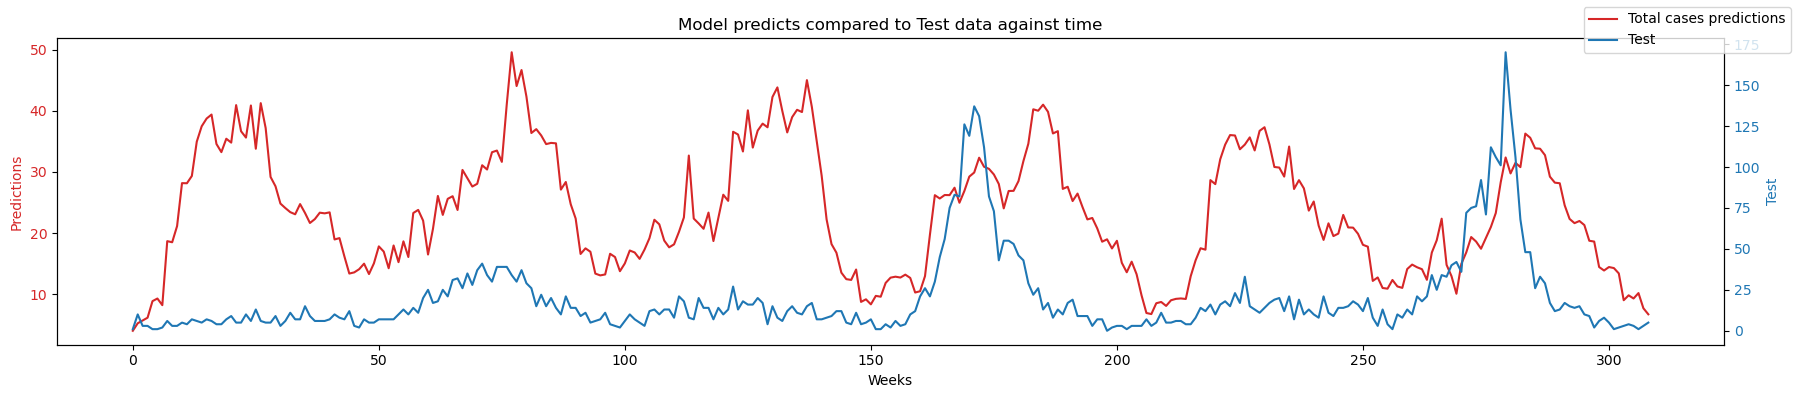

In [24]:
row = 17
y_pred = plots_sj[row]['pred_test']
y = plots_sj[row]['y_test']
test_or_train = 'Test'
dv.plot_train_test(y_pred, y, test_or_train=test_or_train)

## 4) Predict on test data with chosen model and write file

Repeat the above transforms on the test set

In [25]:
# Code to run pipeline on dataset including test_features, and then take only test_features to run the final model
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=True)

# Run processing and split by city
Xy_iq_comb = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=True)
Xy_sj_comb = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=True)
assert Xy_iq_comb.isnull().any().any() == False
assert Xy_sj_comb.isnull().any().any() == False

# Run feature engineering 
Xy_iq_comb = fe.cyclical_encode_date(Xy_iq_comb)
Xy_sj_comb = fe.cyclical_encode_date(Xy_sj_comb)
#Xy_iq_comb = fe.shift_features(Xy_iq_comb, periods=1)
#Xy_sj_comb = fe.shift_features(Xy_sj_comb, periods=1)
Xy_iq_comb = fe.drop_date(Xy_iq_comb)
Xy_sj_comb = fe.drop_date(Xy_sj_comb)
Xy_iq_comb = fe.add_rolling(Xy_iq_comb, 'iq', fillna=True)
Xy_sj_comb = fe.add_rolling(Xy_sj_comb, 'sj', fillna=True)
Xy_iq_comb = fe.remove_original_cols(Xy_iq_comb)
Xy_sj_comb = fe.remove_original_cols(Xy_sj_comb)
print(f'Xy_iq_comb shape: {Xy_iq_comb.shape}') 
print(f'Xy_sj_comb shape: {Xy_sj_comb.shape}') 

# Split data into X and y
X_iq_comb = Xy_iq_comb.drop(labels=['total_cases'], axis=1)
y_train_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] >= 0, Xy_iq_comb.columns == 'total_cases']
y_test_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] < 0, Xy_iq_comb.columns == 'total_cases']
X_sj_comb = Xy_sj_comb.drop(labels=['total_cases'], axis=1)
y_train_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] >= 0, Xy_sj_comb.columns == 'total_cases']
y_test_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] < 0, Xy_sj_comb.columns == 'total_cases']

# Take now only the test features 
X_train_iq = X_iq_comb.iloc[:(X_iq_comb.shape[0] - y_test_iq.shape[0]) , :]
X_train_sj = X_sj_comb.iloc[:(X_sj_comb.shape[0] - y_test_sj.shape[0]) , :]
X_test_iq = X_iq_comb.iloc[(X_iq_comb.shape[0] - y_test_iq.shape[0]): , :]
X_test_sj = X_sj_comb.iloc[(X_sj_comb.shape[0] - y_test_sj.shape[0]): , :]

print(X_train_iq.shape, y_train_iq.shape)
print(X_train_sj.shape, y_train_sj.shape)
assert (X_train_iq.shape[0] == y_train_iq.shape[0])
assert (X_train_sj.shape[0] == y_train_sj.shape[0])


Xy_iq_comb shape: (619, 26)
Xy_sj_comb shape: (1188, 26)
(463, 25) (463, 1)
(928, 25) (928, 1)


In [34]:
assert 1 == 2, "This is not true"

AssertionError: This is not true

In [26]:
# Select data and chosen model and hyperparameters for final prediction

params = dict(learning_rate=0.05,
        n_estimators=100,
        max_depth=5,
        subsample=0.6,
        colsample_bytree=0.8,
        reg_lambda=10,
        gamma=10)
 
# Iquitos, iq
X_test_iq = X_test_iq
X_train_iq = X_train_iq
y_train_iq = y_train_iq
model_iq = 'XGBRegressor'
params_iq = params

# San Jose, sj
X_test_sj = X_test_sj
X_train_sj = X_train_sj
y_train_sj = y_train_sj
model_sj = 'XGBRegressor'
params_sj = params


In [27]:
# Do final prediction and create final DataFrame for submission 
iq_preds = fp.final_predict(X_test_iq, X_train_iq, y_train_iq, city='iq', model=model_iq, params=params_iq)
sj_preds = fp.final_predict(X_test_sj, X_train_sj, y_train_sj, city='sj', model=model_sj, params=params_sj)
final_iq = test_features.loc[test_features.city == 'iq', ['city','year','weekofyear']]
final_sj = test_features.loc[test_features.city == 'sj', ['city','year','weekofyear']]

assert len(iq_preds) == final_iq.shape[0]
assert len(sj_preds) == final_sj.shape[0]

final_iq['total_cases'] = iq_preds.tolist()
final_sj['total_cases'] = sj_preds.tolist()
final = pd.concat([final_sj, final_iq], axis=0)
final['total_cases'] = final['total_cases'].astype(int)

assert final.isnull().any().any() == False
assert final.shape[0] == 416


### Compare predictions fron training data to actual cases

In [28]:
preds_train_iq, y_train_iq = fp.preds_for_plot(X_test_iq, X_train_iq, y_train_iq, model=model_iq, params=params_iq)
preds_train_sj, y_train_sj = fp.preds_for_plot(X_test_sj, X_train_sj, y_train_sj, model=model_sj, params=params_sj)

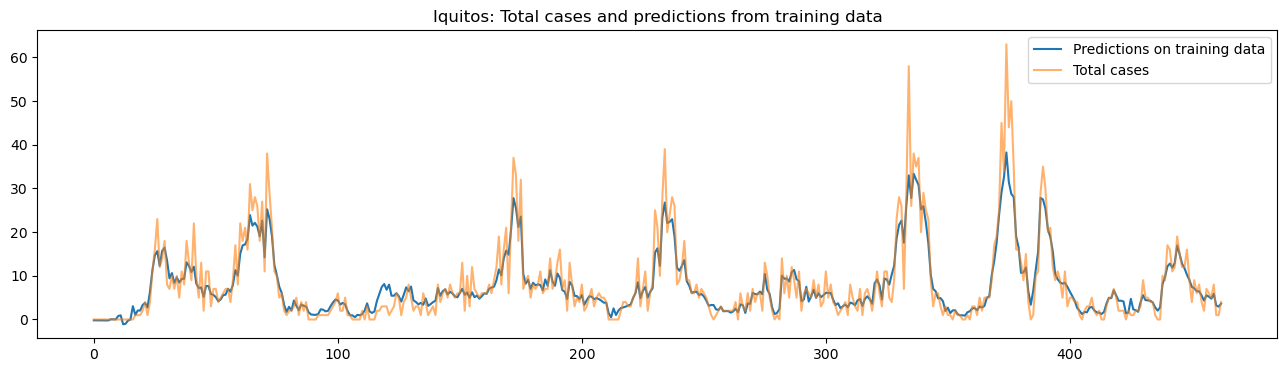

In [29]:
plt.figure(figsize=(16,4))
x = np.arange(preds_train_iq.shape[0])
plt.plot(x, preds_train_iq, label='Predictions on training data')
plt.plot(x, y_train_iq, label='Total cases', alpha=0.6)
plt.title('Iquitos: Total cases and predictions from training data')
plt.legend();

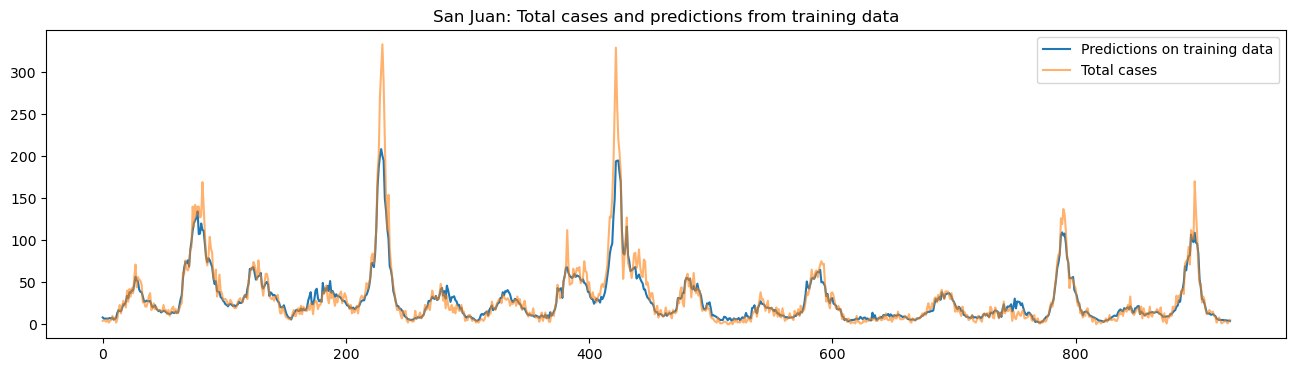

In [30]:
plt.figure(figsize=(16,4))
x = np.arange(preds_train_sj.shape[0])
plt.plot(x, preds_train_sj, label='Predictions on training data')
plt.plot(x, y_train_sj, label='Total cases', alpha=0.6)
plt.title('San Juan: Total cases and predictions from training data')
plt.legend();

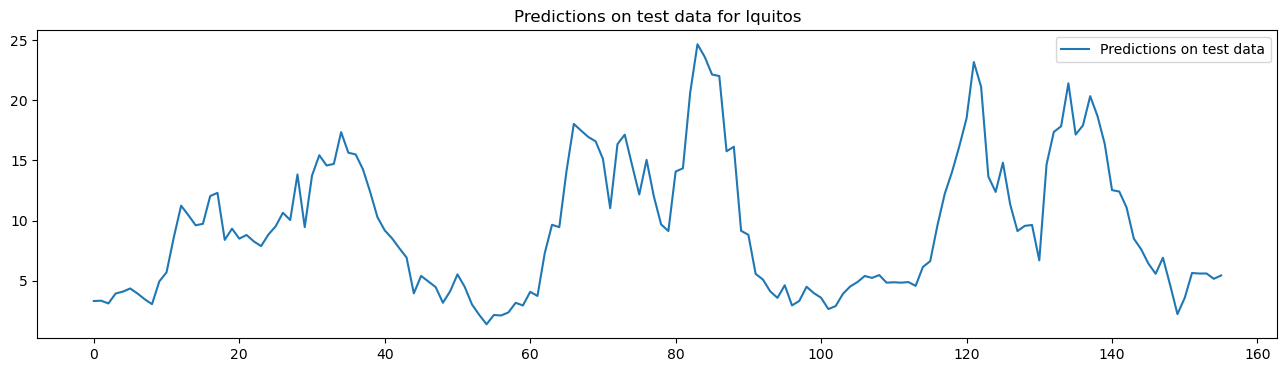

In [31]:
# Plot predictions on test data 
plt.figure(figsize=(16,4))
plt.plot(iq_preds, label='Predictions on test data')
plt.title('Predictions on test data for Iquitos')
plt.legend()

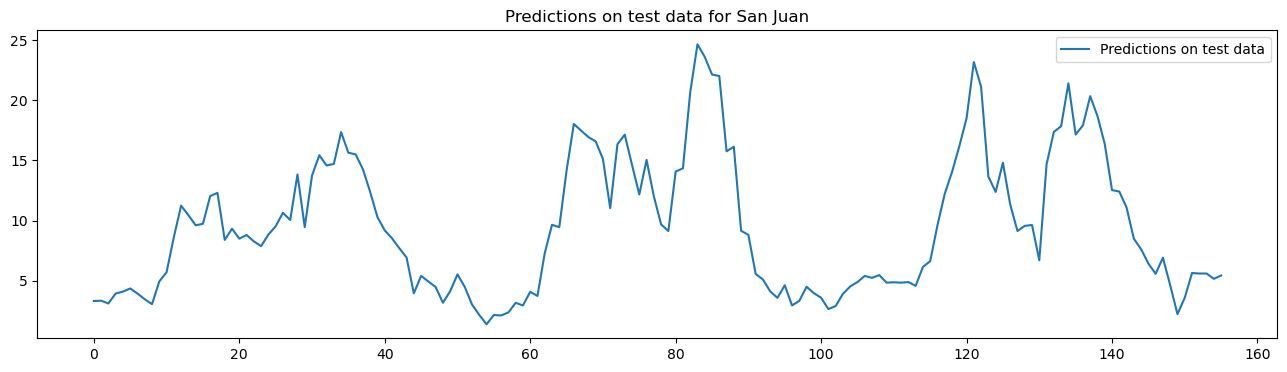

In [32]:
# Plot predictions on test data 
plt.figure(figsize=(16,4))
plt.plot(iq_preds, label='Predictions on test data')
plt.title('Predictions on test data for San Juan')
plt.legend()

### Write final predictions to csv final for submission

In [33]:
# Write to file for submission 
print('Writing submission file to folder: ')
final.to_csv('for_submission_XGB_no_shift.csv', index=False)

Writing submission file to folder: 


## FINAL SUBMISSION SCORE for MAE:  **24.2**

## How to improve from here
- More feature engineering
- Different models (such as LSTM neural network)